In [1]:
import numpy as np
import matplotlib.pyplot as plt
from jax import grad
import jax.numpy as jnp

import sys
sys.path.insert(0, "../../project_2/src")

import CostFunctions as cfunc
import NeuralNetwork as NN
import ActivationFunctions as afunc

Consider the ODE
$$g'(x) = -\gamma(x)$$
with analytic solution
$$g(x) = -g_0 \exp(-\gamma x)$$

with $g_0=1, \gamma = 10$ for $x \in [0,1]$

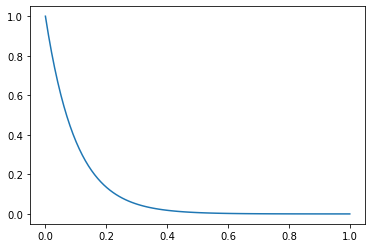

In [2]:
x = np.linspace(0, 1, 100)
gamma = 10
g0 = 1
g = lambda x : g0 * np.exp(- gamma * x)
plt.plot(x, g(x))

can rewrite the ODE as
$$ g'(t) + \gamma g(t) = 0$$
yielding the cost function
$$C[g] = \frac{1}{N} \sum_{i=1}^N (g'(t) + \gamma g(t))^2$$

Propose a trial solution in the form
$$ g_t(t) = g_0 + x \cdot N(t, \{\pmb w\}, \{\pmb b\})$$

$\implies g_t(x=0) = g_0$, initial condition is satisfied

In [3]:
class ODE_exponential_growth(cfunc.CostFunction):
    
    def evaluate_gradient(model, data):
        u_trial = g0 + data * model
        dudx = grad(g0 + data * model)
        return np.sum(dudx(data) + (gamma))**2
    
    
# The cost function:
def cost_function(P, x):

    # Evaluate the trial function with the current parameters P
    g_t = g_trial(x,P)

    # Find the derivative w.r.t x of the neural network
    d_net_out = elementwise_grad(neural_network,1)(P,x)

    # Find the derivative w.r.t x of the trial function
    d_g_t = elementwise_grad(g_trial,0)(x,P)

    # The right side of the ODE
    func = g(x, g_t)

    err_sqr = (d_g_t - func)**2
    cost_sum = np.sum(err_sqr)

    return cost_sum / np.size(err_sqr)

In [5]:
FFNN = NN.FeedForwardNeuralNetwork(
    X = np.linspace(0, 1, 100).reshape(-1, 1),
    Y = np.linspace(0, 1, 100).reshape(-1, 1),
    network_shape = [100],
    activation = afunc.ReLU
)

TypeError: __init__() missing 1 required positional argument: 'activation_out'

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

x = torch.linspace(0, 2*np.pi, 10, requires_grad=True)
print(x)
y = x ** 2
print(y)
z = torch.sqrt(y).mean()
print(z)
z.backward()

tensor([0.0000, 0.6981, 1.3963, 2.0944, 2.7925, 3.4907, 4.1888, 4.8869, 5.5851,
        6.2832], requires_grad=True)
tensor([ 0.0000,  0.4874,  1.9496,  4.3865,  7.7982, 12.1847, 17.5460, 23.8820,
        31.1928, 39.4784], grad_fn=<PowBackward0>)
tensor(3.1416, grad_fn=<MeanBackward0>)


In [ ]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
from matplotlib import pyplot as plt

def sigmoid(z):
    return 1/(1 + np.exp(-z))

# Assuming one input, hidden, and output layer
def neural_network(params, x):

    # Find the weights (including and biases) for the hidden and output layer.
    # Assume that params is a list of parameters for each layer.
    # The biases are the first element for each array in params,
    # and the weights are the remaning elements in each array in params.

    w_hidden = params[0]
    w_output = params[1]

    # Assumes input x being an one-dimensional array
    num_values = np.size(x)
    x = x.reshape(-1, num_values)

    # Assume that the input layer does nothing to the input x
    x_input = x

    ## Hidden layer:

    # Add a row of ones to include bias
    x_input = np.concatenate((np.ones((1,num_values)), x_input ), axis = 0)

    z_hidden = np.matmul(w_hidden, x_input)
    x_hidden = sigmoid(z_hidden)

    ## Output layer:

    # Include bias:
    x_hidden = np.concatenate((np.ones((1,num_values)), x_hidden ), axis = 0)

    z_output = np.matmul(w_output, x_hidden)
    x_output = z_output

    return x_output

# The trial solution using the deep neural network:
def g_trial(x,params, g0 = 10):
    return g0 + x*neural_network(params,x)

# The right side of the ODE:
def g(x, g_trial, gamma = 2):
    return -gamma*g_trial

# The cost function:
def cost_function(P, x):

    # Evaluate the trial function with the current parameters P
    g_t = g_trial(x,P)

    # Find the derivative w.r.t x of the neural network
    d_net_out = elementwise_grad(neural_network,1)(P,x)

    # Find the derivative w.r.t x of the trial function
    d_g_t = elementwise_grad(g_trial,0)(x,P)

    # The right side of the ODE
    func = g(x, g_t)

    err_sqr = (d_g_t - func)**2
    cost_sum = np.sum(err_sqr)

    return cost_sum / np.size(err_sqr)

# Solve the exponential decay ODE using neural network with one input, hidden, and output layer
def solve_ode_neural_network(x, num_neurons_hidden, num_iter, lmb):
    ## Set up initial weights and biases

    # For the hidden layer
    p0 = npr.randn(num_neurons_hidden, 2 )

    # For the output layer
    p1 = npr.randn(1, num_neurons_hidden + 1 ) # +1 since bias is included

    P = [p0, p1]

    print('Initial cost: %g'%cost_function(P, x))

    ## Start finding the optimal weights using gradient descent

    # Find the Python function that represents the gradient of the cost function
    # w.r.t the 0-th input argument -- that is the weights and biases in the hidden and output layer
    cost_function_grad = grad(cost_function,0)

    # Let the update be done num_iter times
    for i in range(num_iter):
        # Evaluate the gradient at the current weights and biases in P.
        # The cost_grad consist now of two arrays;
        # one for the gradient w.r.t P_hidden and
        # one for the gradient w.r.t P_output
        cost_grad =  cost_function_grad(P, x)

        P[0] = P[0] - lmb * cost_grad[0]
        P[1] = P[1] - lmb * cost_grad[1]

    print('Final cost: %g'%cost_function(P, x))

    return P

def g_analytic(x, gamma = 2, g0 = 10):
    return g0*np.exp(-gamma*x)

# Solve the given problem
if __name__ == '__main__':
    # Set seed such that the weight are initialized
    # with same weights and biases for every run.
    npr.seed(15)

    ## Decide the vales of arguments to the function to solve
    N = 10
    x = np.linspace(0, 1, N)

    ## Set up the initial parameters
    num_hidden_neurons = 10
    num_iter = 10000
    lmb = 0.001

    # Use the network
    P = solve_ode_neural_network(x, num_hidden_neurons, num_iter, lmb)

    # Print the deviation from the trial solution and true solution
    res = g_trial(x,P)
    res_analytical = g_analytic(x)

    print('Max absolute difference: %g'%np.max(np.abs(res - res_analytical)))

    # Plot the results
    plt.figure(figsize=(10,10))

    plt.title('Performance of neural network solving an ODE compared to the analytical solution')
    plt.plot(x, res_analytical)
    plt.plot(x, res[0,:])
    plt.legend(['analytical','nn'])
    plt.xlabel('x')
    plt.ylabel('g(x)')
    plt.show()
